# Homework Machine Model Setup

Transformers are commonly used for the problem/field of question answering. As a type of neural network, transformers can do their job very well when given the right architecture and enough data. Below, we explore some different models using the `transformers` library. Created by Huggingface, you can get pretrained transformers very easily. 

If you want to go the not-so-easy route (and preferably have GPUs/TPUs), you might want to take a look at the short section below where I lay out steps you'd need to take to train an `ALBERT` model on the SQuAD dataset. Note that I didn't go this route because I didn't believe it was worth spending money or credits on compute and I didn't want my laptop running for days on end with potentially subpar results. 

The idea of training a model on my laptop was why I initially chose ALBERT to use for the Homework Machine - it's a lighter weight model compared to its better known relative, BERT. The below section explains how you would go about training ALBERT on the squad 2 dataset for those interested.

## ALBERT Setup & Tuning

To start off, we'll want to clone the [ALBERT repo](https://github.com/google-research/albert) and following the [fine-tuning on SQuAD](https://github.com/google-research/albert#fine-tuning-on-squad) instructions. The `pip` command below will do it for you. Just don't be like me and be sure to fill out the `...` where appropriate. 

That said, what should we replace the ellipses with? It wasn't super clear to me initially, so I added some comments below to help out anyone who wants to try out this training method. Some are file locations you want to create, others are from files you'll need to download from elsewhere. Let's take a look:

```
pip install -r albert/requirements.txt
python -m albert.run_squad_v2 \
  --albert_config_file=... \            # download an ALBERT model (ex. https://tfhub.dev/google/albert_large/3, 
                                        #   links in the readme of ALBERT) and within its folder, use 
                                        #   \{your_model}\assets\albert_config.json 
                                        #   (your_model = albert_large_3 for the ex)
                                        
  --output_dir=... \                    # output location (not sure what that output is at the moment)
  
  --train_file=... \                    # for squad (v2), this is the location of train-v2.0.json 
                                        #   (downloaded from https://rajpurkar.github.io/SQuAD-explorer/)
                                        
  --predict_file=... \                  # same as above, except use dev-v2.0.json
  
  --train_feature_file=... \            # a file made by TFRecordWriter. I called this file train_feature_file.tf
  
  --predict_feature_file=... \          # assumed to be the same as above
  
  --predict_feature_left_file=... \     # assumed to be the same as above
  
  --init_checkpoint=... \               # as mentioned in the readme, can instead put:
                                        #   --albert_hub_module_handle=https://tfhub.dev/google/albert_base/1
                                        #   I have no checkpoints made so I'm fine with using their suggestion
                                        
  --spm_model_file=... \                # from your downloaded model, something analagous to 
                                        #   \albert_large_3\assets\30k-clean.model 
                                        #   (albert_large_3 is the model I'll be using)
                                        
  --do_lower_case \
  --max_seq_length=384 \
  --doc_stride=128 \
  --max_query_length=64 \
  --do_train \
  --do_predict \
  --train_batch_size=48 \
  --predict_batch_size=8 \
  --learning_rate=5e-5 \
  --num_train_epochs=2.0 \
  --warmup_proportion=.1 \
  --save_checkpoints_steps=5000 \
  --n_best_size=20 \
  --max_answer_length=30
```
There are a number of settings I didn't touch on - I'm sure the defaults are reasonable but feel free to look into different setting for things like batch size, epochs and learning rate if you want to make training faster or more manageable given your system's RAM. Definitely worth looking into if training time is a concern.

## Transformers Library Question Answering


In [1]:
# mutes all warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import tensorflow as tf
from transformers import pipeline, QuestionAnsweringPipeline
# importing both torch and tf to see if it resolves model loading errors
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TFAutoModelForQuestionAnswering

import wikipedia

from timeit import timeit
import json
import traceback

Let's first test out that the library works as desired. We'll be using the example for question answering taken from the [huggingface transformers site](https://huggingface.co/transformers/task_summary.html).

In [3]:
model_name = "bert-large-uncased-whole-word-masking-finetuned-squad"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForQuestionAnswering.from_pretrained(model_name)


text = r"""
🤗 Transformers (formerly known as pytorch-transformers and pytorch-pretrained-bert) provides general-purpose
architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural
Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between
TensorFlow 2.0 and PyTorch.
"""
questions = [
    "How many pretrained models are available in 🤗 Transformers?",
    "What does 🤗 Transformers provide?",
    "🤗 Transformers provides interoperability between which frameworks?",
]
for question in questions:
    inputs = tokenizer(question, text, add_special_tokens=True, return_tensors="tf")
    input_ids = inputs["input_ids"].numpy()[0]
    outputs = model(inputs)
    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits
    answer_start = tf.argmax(
        answer_start_scores, axis=1
    ).numpy()[0]  # Get the most likely beginning of answer with the argmax of the score
    answer_end = (
        tf.argmax(answer_end_scores, axis=1) + 1
    ).numpy()[0]  # Get the most likely end of answer with the argmax of the score
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))
    print(f"Question: {question}")
    print(f"Answer: {answer}")

All model checkpoint layers were used when initializing TFBertForQuestionAnswering.

All the layers of TFBertForQuestionAnswering were initialized from the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForQuestionAnswering for predictions without further training.


Question: How many pretrained models are available in 🤗 Transformers?
Answer: over 32 +
Question: What does 🤗 Transformers provide?
Answer: general - purpose architectures
Question: 🤗 Transformers provides interoperability between which frameworks?
Answer: tensorflow 2. 0 and pytorch


Huggingface also has the super easy to use `pipeline` if you don't want a specific model. Below's a very quick demo using the context and questions above.

In [4]:
nlp = pipeline("question-answering")
for question in questions:
    print(f"Question: {question}")
    result = nlp(question=question, context=text)
    print(f"Answer: '{result['answer']}'")


Question: How many pretrained models are available in 🤗 Transformers?
Answer: 'over 32+'
Question: What does 🤗 Transformers provide?
Answer: 'general-purpose
architectures'
Question: 🤗 Transformers provides interoperability between which frameworks?
Answer: 'TensorFlow 2.0 and PyTorch'


Awesome, it works! Next we'll show an example of using another model not in the example. Find a model you want to use from the [models](https://huggingface.co/models) page and put its name into the `model_name` variable. 

I was a bit misled when first trying to use a model such as `deepset/xlm-roberta-large-squad2` when using the tensorflow AutoModelForQuestionAnswering - it showed a `404 can't load weights for...`. This wasn't true for all models, so I eventually though that it might be because the model was only compatible with PyTorch. As you can see below, using torch objects, the loading indeed works. It also brought to my attention that models have a PyTorch and/or TensorFlow tag on their models page (ex. [distilbert-base-uncased-distilled-squad](https://huggingface.co/distilbert-base-uncased-distilled-squad)). This hadn't been obvious to me, so I hope that this was written in the documentation somewhere and I missed it rather than this being a surprise error to users of the library.

Once again, we'll take from the huggingface sample code (no more sample code after this, I promise):

In [5]:
model_name = "ktrapeznikov/albert-xlarge-v2-squad-v2"
# model_name = "deepset/xlm-roberta-large-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name)


for question in questions:
    inputs = tokenizer(question, text, add_special_tokens=True, return_tensors="pt")
    input_ids = inputs["input_ids"].tolist()[0]
    outputs = model(**inputs)
    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits

    answer_start = torch.argmax(
        answer_start_scores
    )  # Get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(answer_end_scores) + 1  # Get the most likely end of answer with the argmax of the score

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

    print(f"Question: {question}")
    print(f"Answer: {answer}")

Question: How many pretrained models are available in 🤗 Transformers?
Answer: over 32+
Question: What does 🤗 Transformers provide?
Answer: general-purpose architectures
Question: 🤗 Transformers provides interoperability between which frameworks?
Answer: tensorflow 2.0 and pytorch


## Wikipedia Package

As those familiar with SQuAD are probably aware, the dataset uses Wikipedia articles. Wikipedia has a huge amount of information, so why not use the `wikipedia` Python package to find the answers to questions our users pose? While there is a newer `Wikipedia-API` package created last year, I'm going to use the `wikipedia` package since it was released back in 2014 and has consequently will have its problems better fleshed out through Github issues and forum questions being raised in the past. It also has all the functionality I need, so that seems sufficient reason for me to use it.

As we saw, with the `transformers` package, the actual question answering is very straightforward provided we have the "context". But a homework machine is supposed to make your life easy - why should you have to paste in the "context" where you think the answer is - at that point you'd already be able to find the answer yourself. So based on the question, the `wikipedia` package will be employed to search and find the context. This doesn't seem like a trivial task, but let's begin with a trivial example and see how this package works.

In [6]:
print('Here is an example of the Wikipedia API at work.\nContent from the "Homework Machine" page:')
print(80*'_')
print(wikipedia.page('Homework Machine', auto_suggest=False).content)

print(80*'_')
print('However, if there is not appropriate entry, we get the following error:')
print(80*'_')
try:
    wikipedia.page('asfdjkl;', auto_suggest=False)
except:
    traceback.print_exc()

Here is an example of the Wikipedia API at work.
Content from the "Homework Machine" page:
________________________________________________________________________________
Homework Machine is the solo debut album of Zild Benitez, the frontman and bassist of IV of Spades. It was released on August 6, 2020 under Warner Music Philippines.


== Background ==
On June 12, 2020, Benitez released "Sinungaling" with its music video on YouTube. Few weeks later, he also released "Dila", along with its music video on July 9, 2020.On August 1, 2020, he posted a picture of the track listing of his solo debut album on Twitter, also announcing the release date of the album on August 6.
With the release of the album, he also released the music video for "Habulan", making it the third single from the album. On September 12, 2020, he released the animated music video of "Alalahanin". He also released the music video for "Takbo Ng Panahon" on October 3, 2020.


== Track listing ==
All tracks are written b

Traceback (most recent call last):
  File "<ipython-input-6-627df3158a01>", line 9, in <module>
    wikipedia.page('asfdjkl;', auto_suggest=False)
  File "C:\Users\dex78\anaconda3\lib\site-packages\wikipedia\wikipedia.py", line 276, in page
    return WikipediaPage(title, redirect=redirect, preload=preload)
  File "C:\Users\dex78\anaconda3\lib\site-packages\wikipedia\wikipedia.py", line 299, in __init__
    self.__load(redirect=redirect, preload=preload)
  File "C:\Users\dex78\anaconda3\lib\site-packages\wikipedia\wikipedia.py", line 345, in __load
    raise PageError(self.title)
wikipedia.exceptions.PageError: Page id "asfdjkl;" does not match any pages. Try another id!


In [7]:
print("Note that if we don't use auto_suggest=False, this may also result in an error.")
print(80*'_')
print("Ubuntu page, auto_suggest=False")
print(80*'_')
print(wikipedia.summary("Ubuntu", auto_suggest=False))
print(80*'_')
print("Ubuntu page, auto_suggest=True (default)")
print(80*'_')
try:
    wikipedia.summary("Ubuntu")
except:
    traceback.print_exc()

Note that if we don't use auto_suggest=False, this may also result in an error.
________________________________________________________________________________
Ubuntu page, auto_suggest=False
________________________________________________________________________________
Ubuntu ( (listen) uu-BUUN-too) is a Linux distribution based on Debian and composed mostly of free and open-source software. Ubuntu is officially released in three editions: Desktop, Server, and Core for Internet of things devices and robots. All the editions can run on the computer alone, or in a virtual machine. Ubuntu is a popular operating system for cloud computing, with support for OpenStack. Ubuntu's default desktop has been GNOME, since version 17.10.Ubuntu is released every six months, with long-term support (LTS) releases every two years. As of 22 April 2021, the most recent long-term support release is 20.04 ("Focal Fossa"), which is supported until 2025 under public support and until 2030 as a paid option

Traceback (most recent call last):
  File "<ipython-input-7-094882dd345f>", line 10, in <module>
    wikipedia.summary("Ubuntu")
  File "C:\Users\dex78\anaconda3\lib\site-packages\wikipedia\util.py", line 28, in __call__
    ret = self._cache[key] = self.fn(*args, **kwargs)
  File "C:\Users\dex78\anaconda3\lib\site-packages\wikipedia\wikipedia.py", line 231, in summary
    page_info = page(title, auto_suggest=auto_suggest, redirect=redirect)
  File "C:\Users\dex78\anaconda3\lib\site-packages\wikipedia\wikipedia.py", line 276, in page
    return WikipediaPage(title, redirect=redirect, preload=preload)
  File "C:\Users\dex78\anaconda3\lib\site-packages\wikipedia\wikipedia.py", line 299, in __init__
    self.__load(redirect=redirect, preload=preload)
  File "C:\Users\dex78\anaconda3\lib\site-packages\wikipedia\wikipedia.py", line 393, in __load
    raise DisambiguationError(getattr(self, 'title', page['title']), may_refer_to)
wikipedia.exceptions.DisambiguationError: "bantu" may refer to:

In [8]:
print(wikipedia.page('computer science').content)

Computer science is the study of algorithmic processes, computational machines and computation itself. As a discipline, computer science spans a range of topics from theoretical studies of algorithms, computation and information to the practical issues of implementing computational systems in hardware and software.Its fields can be divided into theoretical and practical disciplines. For example, the theory of computation concerns abstract models of computation and general classes of problems that can be solved using them, while computer graphics or computational geometry emphasize more specific applications. Algorithms and data structures have been called the heart of computer science. Programming language theory considers approaches to the description of computational processes, while computer programming involves the use of them to create complex systems. Computer architecture describes construction of computer components and computer-operated equipment. Artificial intelligence aims 

So it seems like the Wikipedia package has a few quirks, but has the basics required to have good enough results. Still, let's list out some of the shortcomings so we can manage expectations.

#### Limitations:  
1. Wikipedia does not contain information on every subject (it doesn't even have a page for "The Homework Machine"!)
2. auto_suggest isn't smart - it corrected what was already a valid entry
3. page content can be massive as seen in the computer science code block

So, what can we do about these facts?
#### Solutions:
1. Can't do anything about it, no easily accessible better source of context that I'm aware of.
2. Keep auto_suggest False and introduce some other spell correction method if a word entry is not found.
3. Some method for finding paragraphs that likely have the answer will be employed if the pretrained model can't do a better job on its own. I'm hoping it can handle large pieces of context, but I can check the training data (SQuAD 2) or different queries to see if it's capable.


Let's take a quick look at the contexts used in the SQuAD dataset to see how long the `context` is normally. I'm unsure if this is the appropriate way to cite the SQuAD dataset if it's necessary for me to do, but below is what [their arXiv page](https://arxiv.org/abs/1606.05250) had under "cite as". 

```arXiv:1606.05250 [cs.CL]```

In [16]:
# SQuAD (v2) training json
squad_filename = 'train-v2.0.json'
with open(squad_filename) as f:
    squad = json.load(f)

total_topics = len(squad['data'])
max_topics = 1

num_words = []

j=0
while j < len(squad['data'][0]['paragraphs']):
    words = squad['data'][0]['paragraphs'][j]['context']
    num_words.append(len(words.split()))
    # print Beyonce context strings
#     print(words)
#     print(80*'_')
    j+=1

    
sample_context = squad['data'][0]['paragraphs'][j]['context']
print(sample_context)
words_distribution = np.array(num_words)
print("Mean Number of Words:")
print(round(words_distribution.mean()))

Mean Number of Words:
137.86363636363637


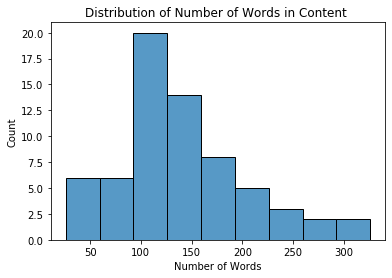

In [20]:
sns.histplot(words_distribution)
plt.xlabel("Number of Words")
plt.title("Distribution of Number of Words in Beyonce Content");

While there's definitely variation and we're only looking at Beyonce data, we see that context is normally a medium sized paragraph. This informs us that models trained on SQuAD likely cannot be fed large chunks of text with the expectation of having a correct answer. Now, we can see if we can confirm this, but targeted context is obviously a plus if possible.

Next, we'll be taking some examples from the SQuAD dataset to see if we can extract appropriate context from Wikipedia articles related to the questions. I should note that it wouldn't be appropriate to test our ML model's performance based on questions used in its training data, however for this task we're just looking at the method to extract `context` so it's not relevant if we're using questions from training.

## Context Extraction